# Previsão do PIB Brasileiro

O Produto Interno Bruto (PIB) é uma das principais medidas utilizadas para avaliar a saúde econômica de um país. Ele representa o valor total de todos os bens e serviços finais produzidos dentro das fronteiras de uma nação durante um determinado período. A análise do PIB é fundamental para entender a dinâmica econômica, orientar políticas públicas e auxiliar na tomada de decisões estratégicas por parte de governos e empresas.

Este projeto tem como objetivo aplicar técnicas de modelagem de séries temporais para analisar e prever o comportamento do PIB do Brasil ao longo dos últimos anos. Utilizando dados históricos, buscamos identificar padrões, tendências e sazonalidades que possam influenciar as previsões futuras do PIB.

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('tableau-colorblind10')

#### Lendo nossos dados e salvando em uma DataFrame

In [296]:
df = pd.read_csv("PIBnacionais.csv",skiprows=4)

#### Excluindo colunas inúteis:

In [297]:
df = df.drop(columns=['Unnamed: 68'])

#### Separando o país que vamos análisar:

In [298]:
pais = 'Brazil'
df_pais = df[df['Country Name'] == pais]

#### Ajustando os dados da Serie Temporal

In [299]:
anos = df_pais.columns[4:]
pib_brasil = df_pais[anos].transpose()
pib_brasil.columns = ['PIB']
pib_brasil = pib_brasil.dropna()

## Verificando se a série é estacionária ou não:

In [300]:
from statsmodels.tsa.stattools import adfuller

In [301]:
resultado_original = adfuller(pib_brasil['PIB'])

print(f'Estatística do Teste ADF: {resultado_original[0]:.3f}')
print(f'P-valor: {resultado_original[1]:.3f}')

Estatística do Teste ADF: -0.848
P-valor: 0.805


#### Resumo dos Resultados do Teste ADF
- Esses resultados altos para valor-p alto (0.805) e a estatística ADF (-0.848) indicam que a série analisada **não é estacionária**, ou seja, suas propriedades estatísticas (como média e variância) mudam ao longo do tempo. 
- Para modelos como o **ARIMA**, que pressupõem que a série seja estacionária, usar uma série não estacionária pode gerar **previsões menos precisas**, já que as tendências de longo prazo interferem no resultado final.
- Portanto, é necessário **transformar** a série (como por meio de diferenciação) antes de aplicar modelos desse tipo.

#### Aplicando a Diferenciação:

In [302]:
pib_brasil_estacionario = pib_brasil.diff().dropna()
resultado_adf = adfuller(pib_brasil_estacionario['PIB'])

In [303]:
resultado_adf = adfuller(pib_brasil_estacionario)
print(f'Estatística do Teste ADF: {resultado_adf[0]:.3f}')
print(f'Valor-p: {resultado_adf[1]:.3f}')

Estatística do Teste ADF: -3.771
Valor-p: 0.003


##### Diferente dos resultados anteriores, agora podemos concluir que a série está estacionária, tornando-a adequada para modelagem com ARIMA ou outros modelos que exigem estacionariedade.

## Gráficos de Autocorrelação

In [304]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

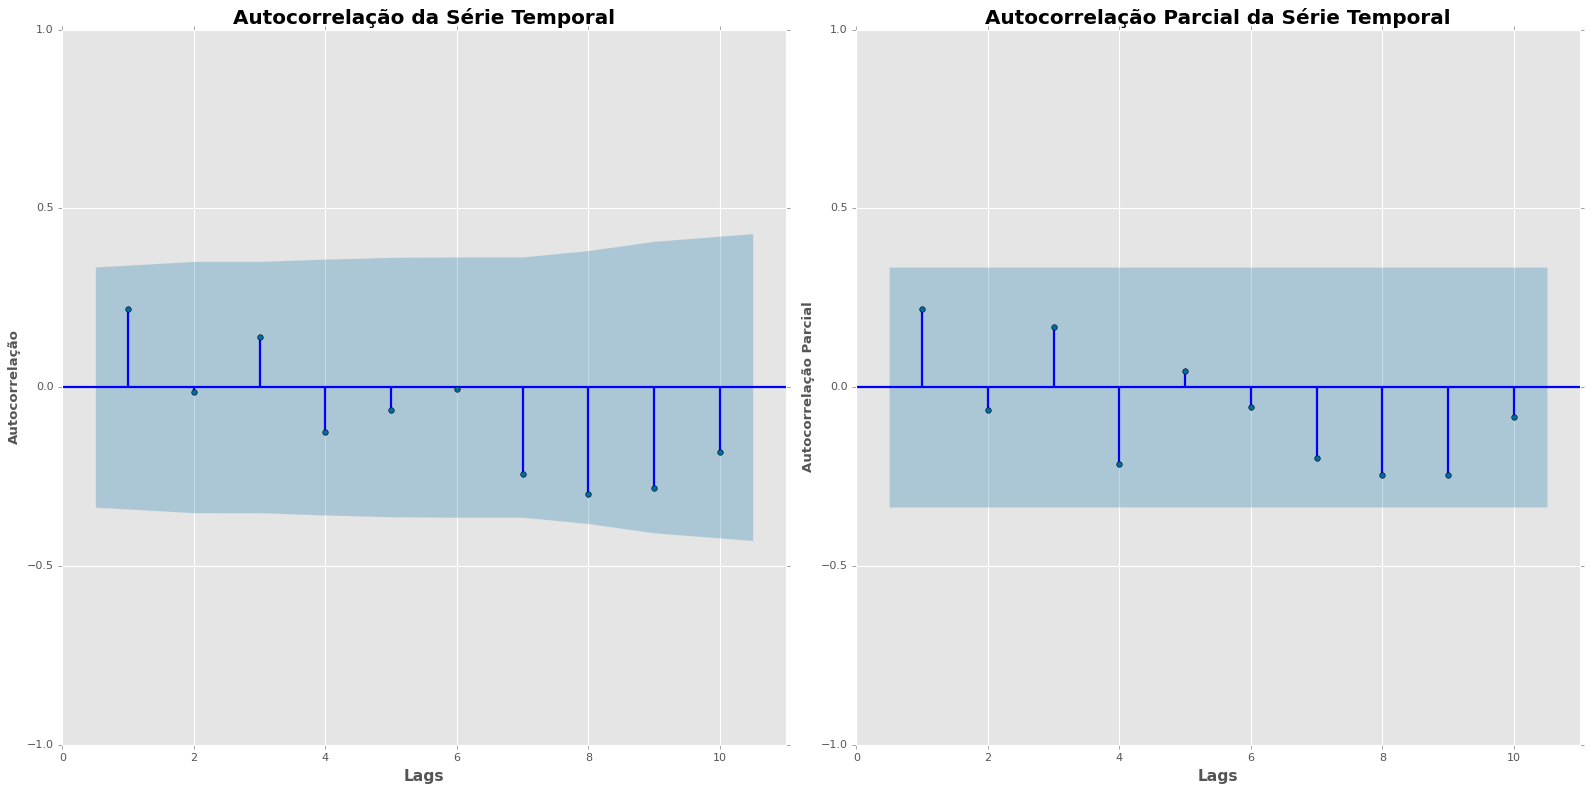

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot de Autocorrelação (FAC)
plot_acf(pib_brasil_estacionario['PIB'], lags=10, ax=ax[0], alpha=0.05, zero=False)
ax[0].set_title('Autocorrelação da Série Temporal', fontsize=18, fontweight='bold')
ax[0].set_xlabel('Lags', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Autocorrelação', fontsize=12, fontweight='bold')
ax[0].grid(True)  

# Plot de Autocorrelação Parcial (FACP)
plot_pacf(pib_brasil_estacionario['PIB'], lags=10, ax=ax[1], alpha=0.05, zero=False)
ax[1].set_title('Autocorrelação Parcial da Série Temporal', fontsize=18, fontweight='bold')
ax[1].set_xlabel('Lags', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Autocorrelação Parcial', fontsize=12, fontweight='bold')
ax[1].grid(True) 

plt.tight_layout()
plt.show()

#### Resumo das Conclusões sobre os Gráficos de Autocorrelação

1. **Função de Autocorrelação (FAC)**:
   - A FAC mostra autocorrelações significativas no lag 1.
   - Os valores se aproximam de zero após o lag 2, sugerindo que a influência dos dados passados diminui rapidamente.

2. **Função de Autocorrelação Parcial (FACP)**:
   - A FACP apresenta padrões semelhantes, com significância nos lags iniciais e valores próximos de zero a partir do lag 2.
   - Isso reforça a ideia de uma estrutura temporal que diminui rapidamente após os primeiros lags.

- A análise deve continuar para avaliar outros aspectos da série, como sazonalidade e tendência, visando uma modelagem e previsão mais precisas.

## Decomposição da Série Temporal

In [306]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 960x480 with 0 Axes>

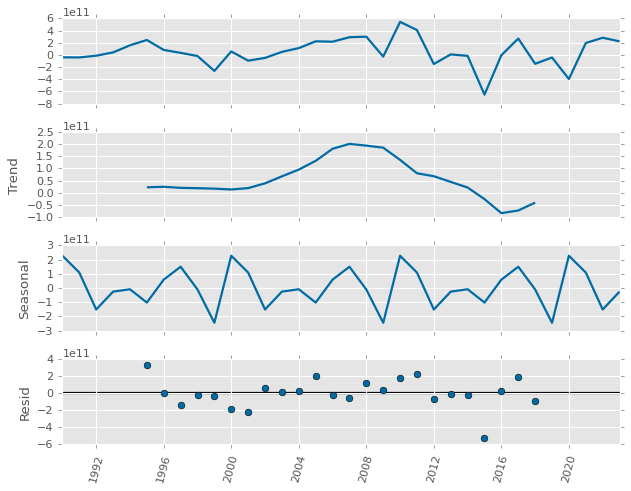

In [321]:
plt.figure(figsize=(12,6))

decomposicao = seasonal_decompose(pib_brasil_estacionario, model='additive', period=10);
decomposicao.plot()

plt.xticks(rotation=75)
plt.show()

#### Conclusões sobre o Gráfico de Decomposição da Série Temporal

1. **Série Original**:
   - A série original apresenta uma variação significativa ao longo do tempo, com picos e vales evidentes.

2. **Tendência**:
   - A componente de tendência mostra uma leve inclinação negativa ao longo do período, indicando que a série pode estar em um processo de desaceleração ou redução no longo prazo.

3. **Sazonalidade**:
   - A componente sazonal é visível, com padrões flutuantes que se repetem ao longo dos anos. Isso sugere a presença de variações sazonais na série, que podem ser influenciadas por fatores específicos de cada período.

4. **Resíduos**:
   - Os resíduos estão centrados em torno de zero, o que é um sinal positivo. No entanto, alguns pontos se afastam da linha média, indicando possíveis outliers.

## Converter o índice para datetime

In [308]:
pib_brasil_estacionario.index = pd.to_datetime(pib_brasil_estacionario.index, format='%Y')

## Modelo auto_arima:

O **auto_arima** é uma técnica automatizada para identificação e ajuste de modelos de séries temporais usando o método ARIMA (AutoRegressive Integrated Moving Average). Ele é especialmente útil em análises econométricas, onde se busca prever variáveis com base em dados históricos.

#### Principais Características:

1. **Automatização**: O Auto ARIMA elimina a necessidade de selecionar manualmente os parâmetros do modelo (p, d, q), pois utiliza algoritmos para determinar a melhor combinação que minimiza critérios de informação, como o AIC (Akaike Information Criterion).

2. **Análise Sazonal**: O modelo pode incorporar componentes sazonais, permitindo a modelagem de dados que exibem padrões que se repetem em intervalos regulares, o que é essencial para séries temporais com sazonalidade.

3. **Flexibilidade**: O Auto ARIMA pode lidar com diferentes tipos de dados, incluindo séries temporais estacionárias e não estacionárias, realizando transformações como diferenciação automaticamente.

4. **Avaliação de Modelos**: A técnica permite a avaliação e comparação de vários modelos, fornecendo diagnósticos que ajudam a identificar o ajuste mais apropriado.

5. **Previsões e Intervalos de Confiança**: O Auto ARIMA gera previsões e calcula intervalos de confiança, permitindo uma análise mais robusta da incerteza nas previsões.

In [309]:
from pmdarima import auto_arima

In [310]:
modelo_auto = auto_arima(pib_brasil_estacionario, seasonal=True, m=10, 
                          trace=True, error_action='ignore', 
                          suppress_warnings=True)

print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[10] intercept   : AIC=1885.280, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[10] intercept   : AIC=1877.660, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[10] intercept   : AIC=1879.122, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[10] intercept   : AIC=1878.435, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[10]             : AIC=1877.406, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[10] intercept   : AIC=1878.241, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[10] intercept   : AIC=1877.012, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[10] intercept   : AIC=1878.630, Time=0.06 sec
 ARIMA(0,0,0)(0,0,2)[10] intercept   : AIC=1878.443, Time=0.07 sec
 ARIMA(0,0,0)(1,0,2)[10] intercept   : AIC=1880.438, Time=0.16 sec
 ARIMA(1,0,0)(0,0,1)[10] intercept   : AIC=1878.303, Time=0.08 sec
 ARIMA(1,0,1)(0,0,1)[10] intercept   : AIC=1879.539, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[10]             : AIC=1885.490, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,1)[10] intercept
Total fit time: 1.018 seconds
        

In [311]:
previsao, intervalo_confianca = modelo_auto.predict(n_periods=10, return_conf_int=True)

anos_previstos = pd.date_range(start=pib_brasil_estacionario.index[-1] + pd.DateOffset(years=0), 
                              periods=10, freq='Y')

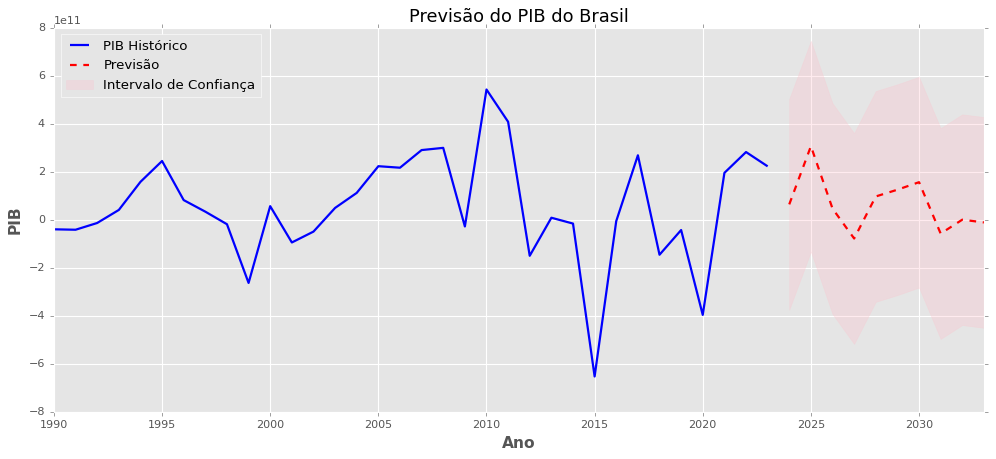

In [313]:
plt.figure(figsize=(15, 6))

#PIB histórico
plt.plot(pib_brasil_estacionario, label='PIB Histórico', color='b', linewidth=2)

#Grafico da previsão
plt.plot(previsao, label='Previsão', color='r', linewidth=2, linestyle='--')

#Preenchendo o intervalo de confiança
plt.fill_between(anos_previstos, 
                 intervalo_confianca[:, 0], 
                 intervalo_confianca[:, 1], 
                 color='pink', alpha=0.3, label='Intervalo de Confiança')

plt.title('Previsão do PIB do Brasil', fontsize=16)
plt.xlabel('Ano', fontsize=14, fontweight='bold')
plt.ylabel('PIB', fontsize=14, fontweight='bold')

plt.grid(True)
plt.legend(loc='upper left')

plt.show()

## Análise dos Resíduos:

In [314]:
residuos = modelo_auto.resid()

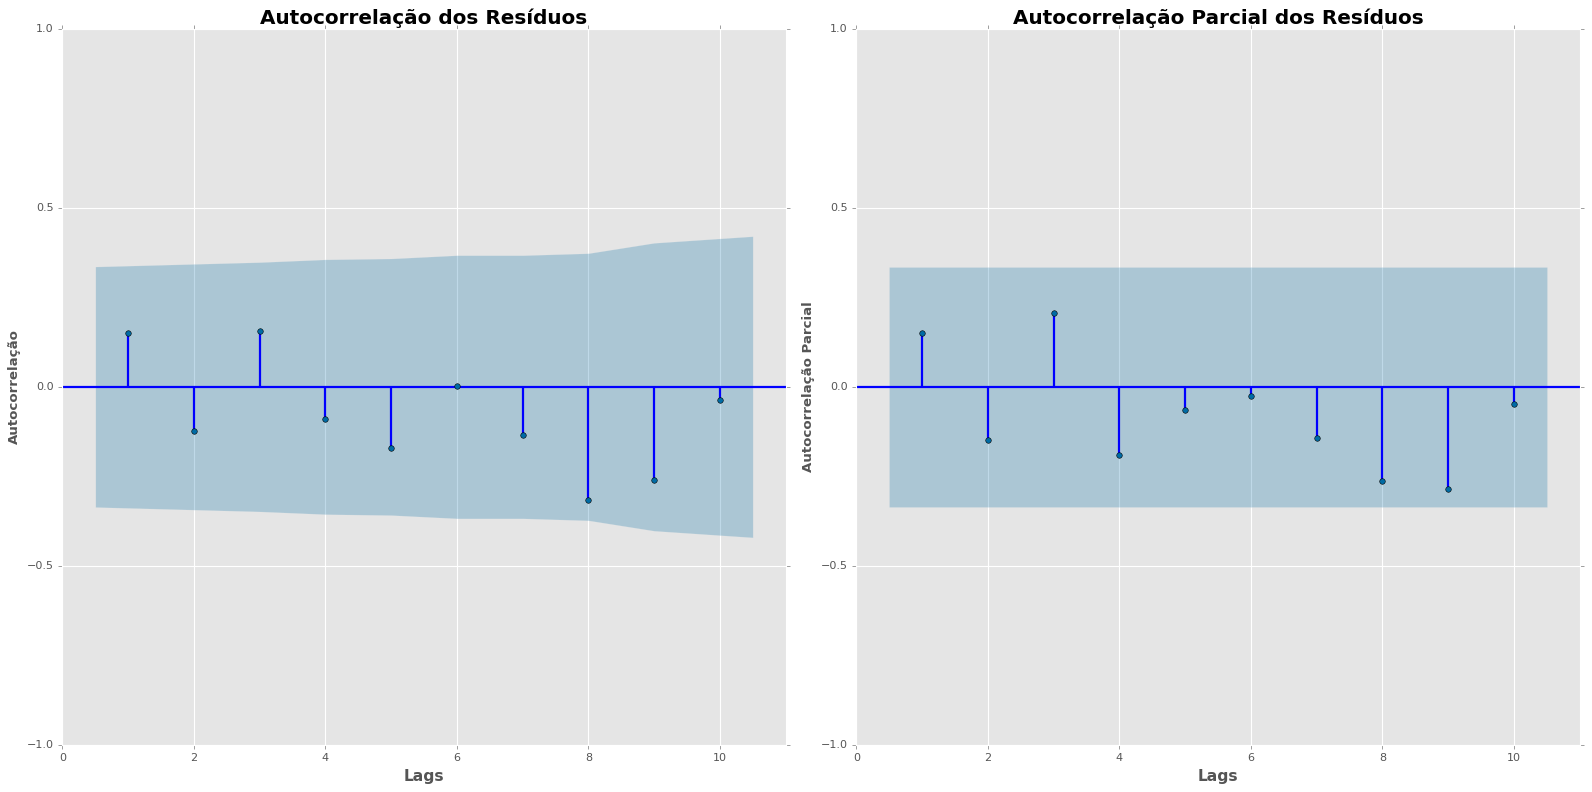

In [324]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_acf(residuos, lags=10, ax=ax[0], alpha=0.05, zero=False)
ax[0].set_title('Autocorrelação dos Resíduos', fontsize=18, fontweight='bold')
ax[0].set_xlabel('Lags', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Autocorrelação', fontsize=12, fontweight='bold')
ax[0].grid(True)  

plot_pacf(residuos, lags=10, ax=ax[1], alpha=0.05, zero=False)
ax[1].set_title('Autocorrelação Parcial dos Resíduos', fontsize=18, fontweight='bold')
ax[1].set_xlabel('Lags', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Autocorrelação Parcial', fontsize=12, fontweight='bold')
ax[1].grid(True) 

plt.tight_layout()
plt.show()

#### Teste de Lungbox

In [316]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [317]:
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
ljung_box_test

,lb_stat,lb_pvalue
10,12.810702,0.234449


## Conclusão do Projeto

Neste projeto, realizamos uma análise abrangente da série temporal do PIB do Brasil utilizando o modelo ARIMA. Através de uma busca passo a passo para minimizar o AIC, encontramos o melhor modelo, que foi identificado como **ARIMA(0,0,0)(0,0,1)[10]**, com um AIC de **1877.012**. O tempo total de ajuste foi de **0.766 segundos**.


#### Resultados do Modelo 
Os resultados do modelo indicaram:

- **Intercepto:** \(5.141 \times 10^{10}\)
- **MA de Sazonalidade Lag 10:** \(-0.4209\) com p-valor de \(0.042\)
- **Variância do Erro (\(\sigma^2\)):** \(5.017 \times 10^{22}\)

Além disso, os resultados do teste de Ljung-Box mostraram:

| lb_stat   | lb_pvalue   |
|-----------|-------------|
| 12.810702       | 0.234449    |

Esses resultados sugerem que não há autocorrelação significativa nos resíduos do modelo, o que é confirmado pela análise gráfica, onde os resíduos se comportam como ruídos brancos, não ultrapassando os limites de confiança.

#### Considerações Finais
A conclusão é que o modelo utilizado foi adequado para a previsão do PIB, apresentando resultados que se alinham com os padrões esperados. As previsões geradas são confiáveis e podem ser utilizadas para orientar decisões econômicas futuras.
